# Comparison of all Pedersen N02 cases

## Nalu-Wind/AMR-Wind/SOWFA vs Pedersen (2014) results

Comparison between our runs and Pedersen's 2014 paper

**Note**: Sandians run using `canopy/2.1.9` to get all of the right libraries

In [1]:
%%capture
import sys
sys.path.insert(1, '../utilities')
import windspectra, load_data
import numpy as np
import matplotlib.pyplot as plt

#from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
# Provide locations and parameters of data
l_cases = {
    'amrwind-ksgs-lim':   load_data.AMRWindStats('AmrWind'),
    #'naluwind-smag':      load_data.NaluWindStats('NaluWindRun02'),
    'naluwind-ksgs':      load_data.NaluWindStats('NaluWindRun03'),
    'Pedersen:2014':      load_data.PedersonData('pedersen2014_data'),
    'SOWFA':              load_data.NaluWindStats('SOWFA'),
    'amrwind-ksgs-nolim': load_data.AMRWind2Stats('AmrWind_KSGS_NoLim'),
    'amrwind-smag-lim':   load_data.AMRWind2Stats('AmrWind_Smag_Lim'),
    'amrwind-smag-nolim': load_data.AMRWind2Stats('AmrWind_Smag_NoLim'),
    }

# What kind of line styles to use in the plots
styles = {
    'amrwind-ksgs-lim':     {'color':'r',         'lw':2, 'ls':'-',  'plotspectra':True},
#    'naluwind-smag': {'color':'c', 'lw':1, 'ls':'-', 'plotspectra':True},
    'naluwind-ksgs':        {'color':'b',         'lw':2, 'ls':'-',  'plotspectra':True},
    'Pedersen:2014':        {'color':'k',         'lw':3, 'ls':'-',  'plotspectra':False},
    'SOWFA':                {'color':'g',         'lw':2, 'ls':'-',  'plotspectra':True},
    'amrwind-ksgs-nolim':   {'color':'r',         'lw':2, 'ls':'--', 'plotspectra':True},
    'amrwind-smag-lim':     {'color':'orange',    'lw':1, 'ls':'-',  'plotspectra':True},
    'amrwind-smag-nolim':   {'color':'orange',    'lw':1, 'ls':'--', 'plotspectra':True},
}

deltaX=3000.0/288         # Grid spacing


## Plot velocity profiles

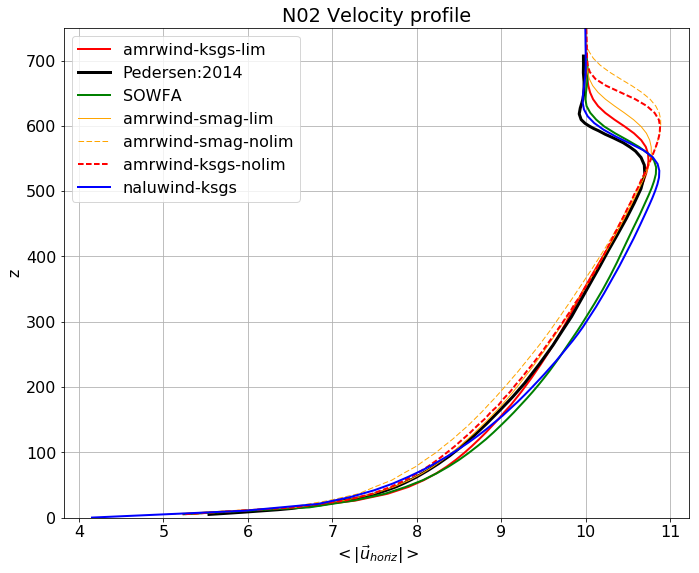

In [3]:
fig = plt.figure(figsize=(10,8))
plt.rc('font', size=16)

for l,c in l_cases.items():
    ls=styles[l]
    plt.plot(c.hvelmag, c.z, label=l, color=ls['color'], linewidth=ls['lw'], linestyle=ls['ls'])
plt.ylim()
plt.xlabel(r'$< | \vec{u}_{horiz} | >$')
plt.ylabel('z')
plt.legend(loc=0)
plt.ylim(0,750)
plt.grid()
plt.tight_layout()
plt.title('N02 Velocity profile')


## Plot temperature

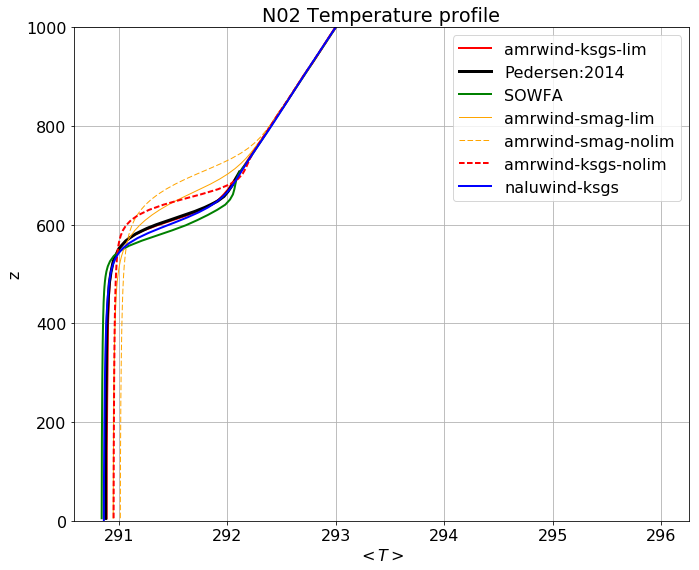

In [4]:
fig = plt.figure(figsize=(10,8))
plt.rc('font', size=16)

for l,c in l_cases.items():
    ls=styles[l]
    plt.plot(c.T, c.z, label=l, color=ls['color'], linewidth=ls['lw'], linestyle=ls['ls'])
plt.xlabel(r'$<T>$')
plt.ylabel('z')
plt.legend(loc=0)
plt.ylim(0,1000)
plt.grid()
plt.tight_layout()
plt.title('N02 Temperature profile')

## Plot Reynolds stresses

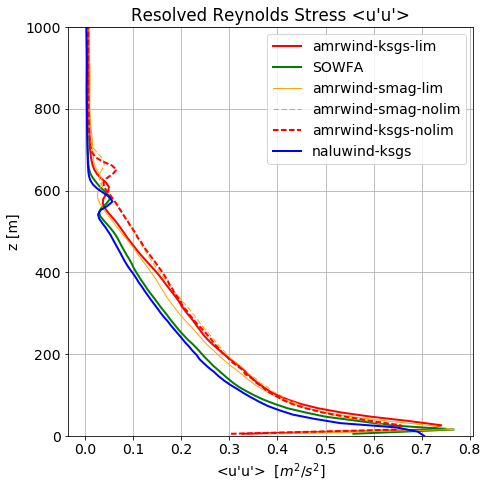

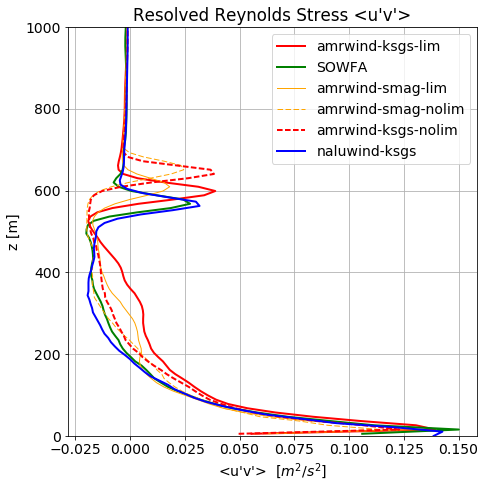

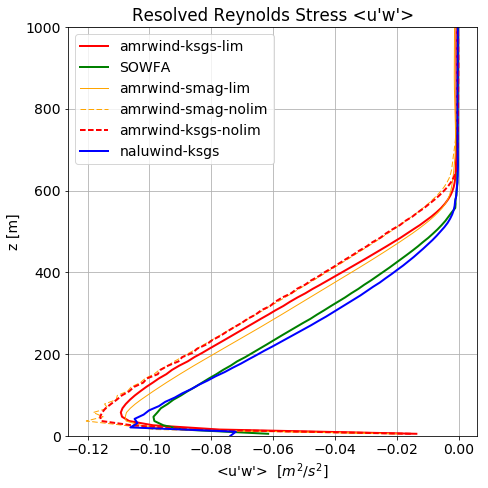

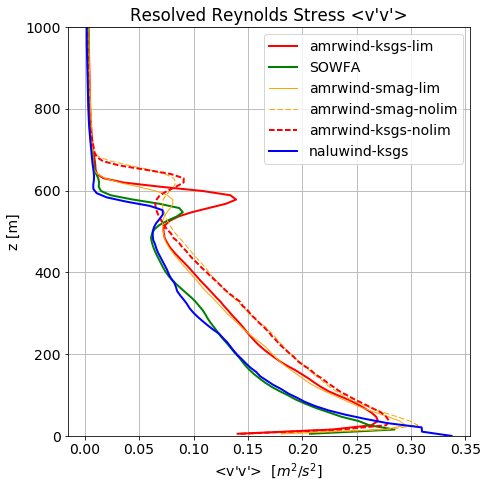

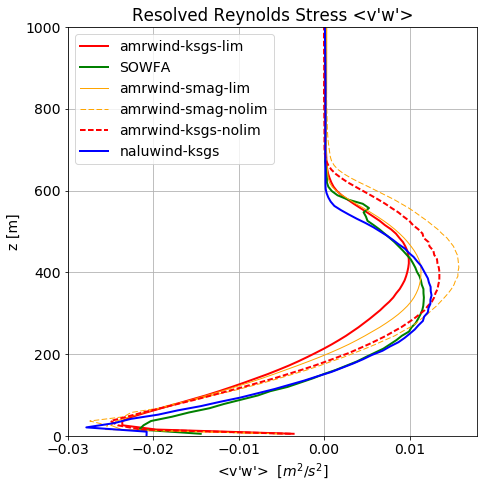

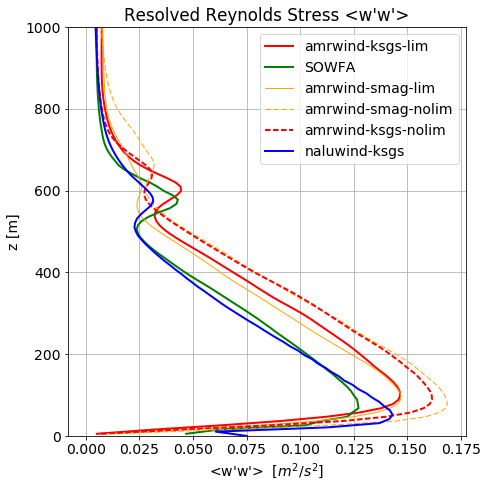

In [5]:
# Plot these stresses in this order
plotstresses=["<u'u'>", "<u'v'>", "<u'w'>", "<v'v'>", "<v'w'>", "<w'w'>"]

for stress in plotstresses:
    fig = plt.figure(figsize=(7,7))
    plt.rc('font', size=14)
    for l,c in l_cases.items():
        ls=styles[l]
        if (len(c.vel_var[stress])>0): 
            plt.plot(c.vel_var[stress], c.z, label=l, color=ls['color'], linewidth=ls['lw'], linestyle=ls['ls'])
    plt.legend()
    plt.ylabel('z [m]')
    plt.xlabel(stress+'  [$m^2/s^2$]')
    plt.ylim([0,1000])
    plt.grid()
    plt.title('Resolved Reynolds Stress '+stress)
    plt.tight_layout()

## Plot Spectra

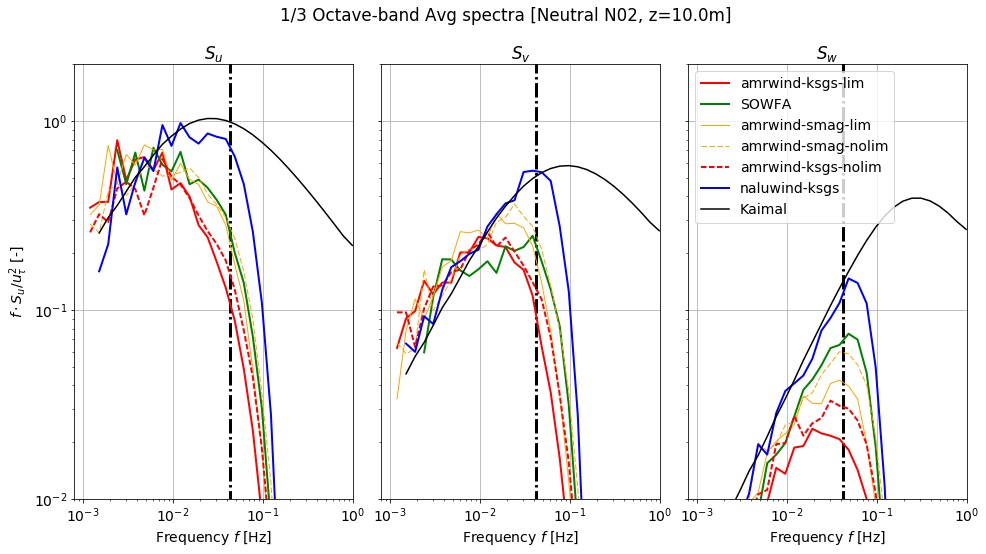

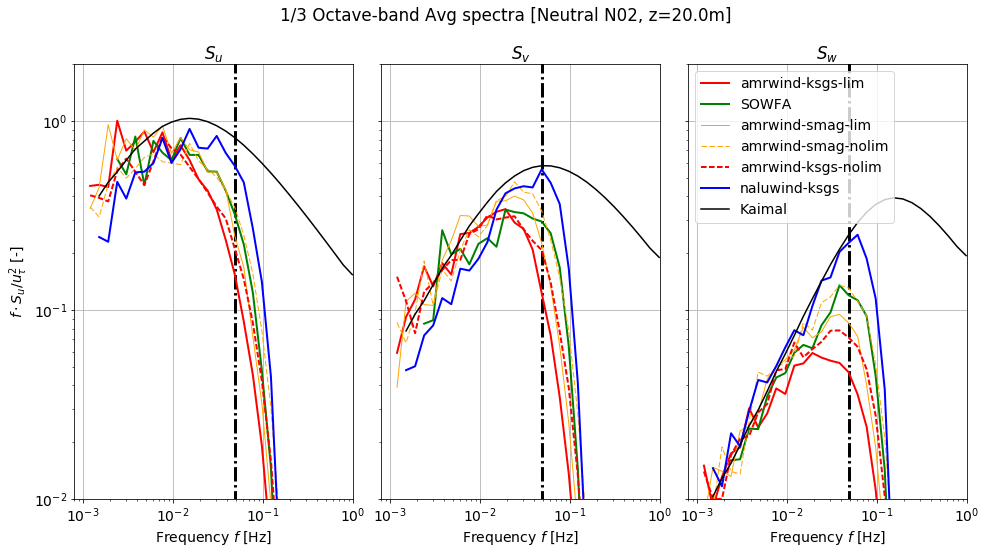

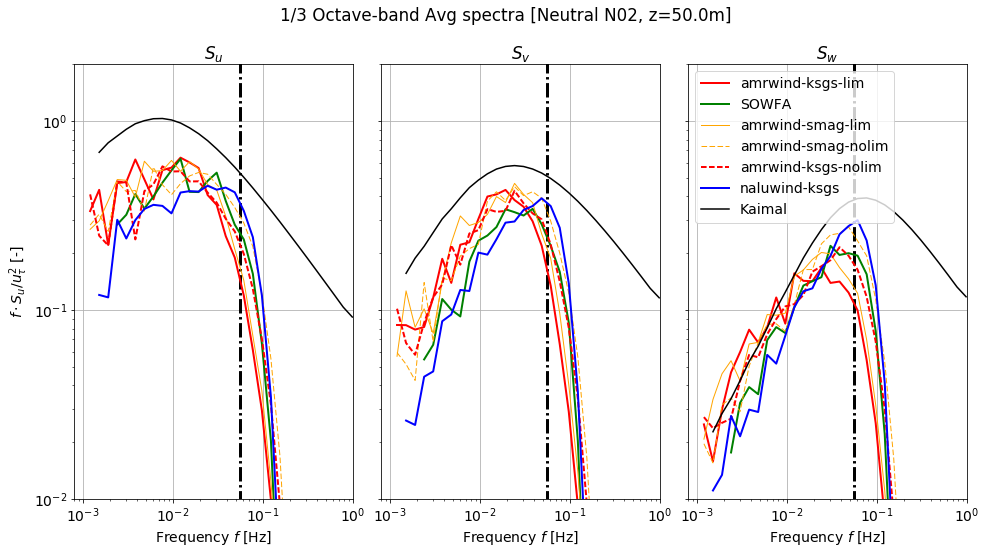

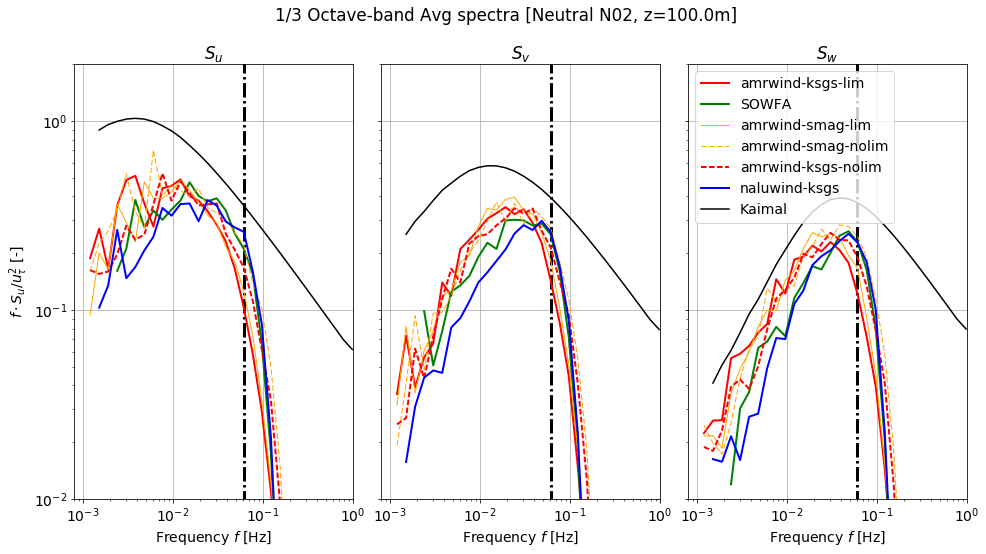

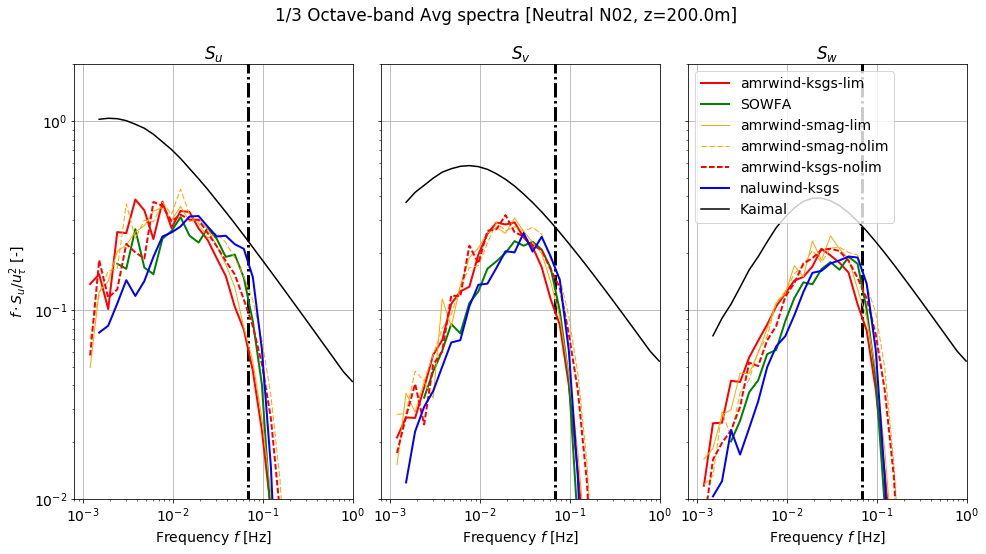

In [6]:
# Plot limits
ylims=[1e-2, 2]
xlims=[8e-4, 1]
lw=0.5
Nband = 3     # Average over 1/Nband Octave bands

# Loop over all heights
for i, z in enumerate(l_cases['naluwind-ksgs'].ps_data['z']):
    fig, axs = plt.subplots(1,3,figsize=(16,8),sharey=True)
    
    # Compute maximum resolvable frequency
    hvelmag = l_cases['naluwind-ksgs'].interp_hvelmag(z)
    fmax = 0.6*hvelmag/(8*deltaX)

    # Plot each case
    for l,c in l_cases.items():
        ls=styles[l]
        if ls['plotspectra']: # Ignore Pedersen, no spectra there
            f, suu, svv, sww = c.point_spectra(z)    
            utau = float(c.istats['ustar'])
            avgf, avgsuu = windspectra.NarrowToOctaveBand(f, suu, Nband)
            avgf, avgsvv = windspectra.NarrowToOctaveBand(f, svv, Nband)
            avgf, avgsww = windspectra.NarrowToOctaveBand(f, sww, Nband)
            
            axs[0].loglog(avgf, avgf*avgsuu/(utau * utau) , color=ls['color'], linewidth=ls['lw'], linestyle=ls['ls'], label=l+' - u')
            axs[1].loglog(avgf, avgf*avgsvv/(utau * utau) , color=ls['color'], linewidth=ls['lw'], linestyle=ls['ls'], label=l+' - v')
            axs[2].loglog(avgf, avgf*avgsww/(utau * utau) , color=ls['color'], linewidth=ls['lw'], linestyle=ls['ls'], label=l)
            
    
    # Plot the Kaimal spectra
    avgf, suuKai = windspectra.NarrowToOctaveBand(f, windspectra.getKaimal(f, z, hvelmag ), Nband)
    avgf, svvKai = windspectra.NarrowToOctaveBand(f, windspectra.getKaimal(f, z, hvelmag, params=windspectra.vKaimalconst), Nband)
    avgf, swwKai = windspectra.NarrowToOctaveBand(f, windspectra.getKaimal(f, z, hvelmag, params=windspectra.wKaimalconst), Nband)
    lineu, = axs[0].loglog(avgf, suuKai, label='Kaimal - u', color='k')
    linev, = axs[1].loglog(avgf, svvKai, label='Kaimal - v', color='k')
    linew, = axs[2].loglog(avgf, swwKai, label='Kaimal', color='k')
    
    # Set individual axes labels
    axs[0].set_ylabel('$f\cdot S_{u}/u_{\\tau}^2$ [-]')
    axs[0].set_title('$S_{u}$')
    axs[1].set_title('$S_{v}$')
    axs[2].set_title('$S_{w}$')
    axs[2].legend(loc='upper left')
    
    # Go set common stuff for all plots
    for iax in range(3):
        axs[iax].vlines(fmax, 5e-4, 20,lw=3, linestyle='-.')
        axs[iax].set_xlim(xlims[0], xlims[1])
        axs[iax].set_ylim(ylims[0], ylims[1])
        axs[iax].grid()
        axs[iax].set_xlabel('Frequency $f$ [Hz]')        
    
    fig.suptitle('1/3 Octave-band Avg spectra [Neutral N02, z={:.1f}m]'.format(z))
    plt.subplots_adjust(wspace=0.1)